### Predicting crop yield using weather and satellite observations

In [3]:
import descarteslabs as dl
from descarteslabs.client.services.tasks import AsyncTasks, as_completed
import numpy as np
import pandas
import json
import cartopy
import shapely
import shapely.geometry
import matplotlib
import matplotlib.pyplot as plt
import folium
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pprint import pprint
import pickle
import calendar
import sklearn
import sklearn.cluster
import sklearn.ensemble

from descarteslabs.client.services import Catalog
from descarteslabs.client.services import Storage

storage_client = Storage()
catalog = Catalog()

product_id = '6298b97d846a85f9045e8173d1f052c571b48cae:demo:crop:iowa:v1'

### Find Corn

In [33]:
# load yield reference data

with open('nass_county_iowa_corn_2017.json') as f:
    reference = json.load(f)

In [5]:
# find Crawford County, IA

slug = dl.places.find('iowa_west-central_crawford')[0]['slug']
county_shape = dl.places.shape(slug)
shape = shapely.geometry.shape(county_shape['geometry'])
output_bounds = shape.bounds

##### Find all the corn in Carroll County, Iowa

In [6]:
metadata = dl.metadata.search(product=['usda:cdl'],
                            start_time = '2017-01-01',
                            end_time = '2018-01-01',
                            place = slug,
                            limit = 500)

In [7]:
arr, meta = dl.raster.ndarray([feature['id'] for feature in metadata['features']], 
                              bands=['class'],
                              data_type='Byte',
                              bounds = output_bounds,
                              bounds_srs = 'EPSG:4326',
                              srs = 'EPSG:32615',
                              resolution = 30.0)

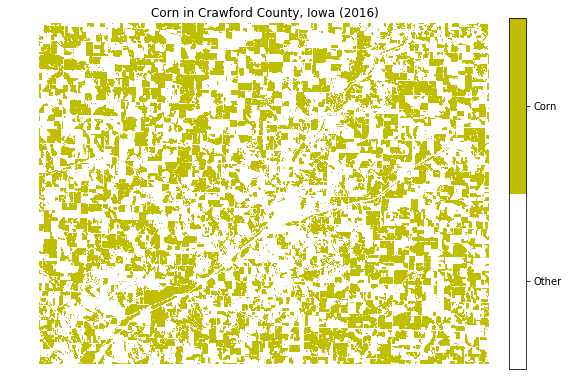

In [8]:
corn = np.where(arr == 1, 1, 0)

colorlist = ['w', 'y']
cmap = colors.ListedColormap(colorlist)
bounds = [0, 1, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(8, 8))
cax = plt.imshow(corn, cmap=cmap, norm=norm)
plt.title('Corn in Crawford County, Iowa (2016)')
cbar = fig.colorbar(cax, ticks=[0.5, 1.5], orientation='vertical', fraction=0.036, pad=0.04)
cbar.ax.set_yticklabels(['Other', 'Corn']) 
plt.axis('off')
plt.tight_layout()

##### Calculate vegetation indicators 

In [9]:
metadata = dl.metadata.search(product=['8291fd932b469d8d81701dd6079d64b0fabc5f93:moody:l8_2017_veg_healthmax:v1'],
                              start_time = '2017-01-01',
                              end_time = '2017-12-31',
                              place = slug,
                              limit = 500)

In [10]:
arr, meta = dl.raster.ndarray([feature['id'] for feature in metadata['features']], 
                              bands=['veg_healthmax'],
                              data_type='Byte',
                              bounds = output_bounds,
                              bounds_srs = 'EPSG:4326',
                              srs = 'EPSG:32615',
                              resolution = 30.0)

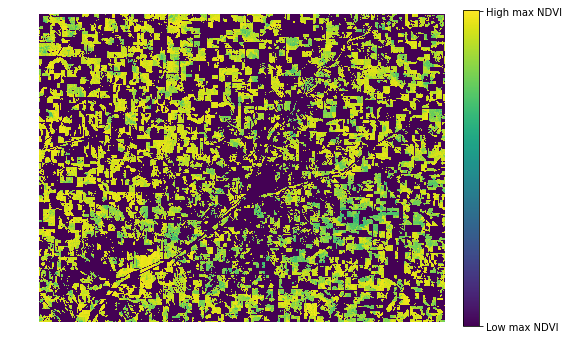

In [11]:
corn_ndvi =np.where(corn == 1, arr, 0)

fig, ax = plt.subplots(figsize=(8, 8))
cax = plt.imshow(corn_ndvi)
cbar = fig.colorbar(cax, ticks=[0, 240], orientation='vertical', fraction=0.036, pad=0.04)
cbar.ax.set_yticklabels(['Low max NDVI', 'High max NDVI']) 
plt.axis('off')
plt.tight_layout()

##### Calculate weather variables

In [12]:
''' DLTiles to create a global tiling across our AOI '''

shape = dl.places.shape('north-america_united-states_iowa')
resolution = 30
tile_dimension = 2048
pad = 0

tiles = dl.raster.dltiles_from_shape(resolution = resolution, 
                                     tilesize = tile_dimension, 
                                     pad = pad, 
                                     shape = shape)

print('Number of tiles = {}'.format(len(tiles['features'])))

Number of tiles = 58


In [18]:
def calculate_gdd_task(tile, shape, start_date, end_date, input_product, output_product):
    """ predict water over dltile with Tasks """
    
    import descarteslabs as dl
    from descarteslabs.client.services.catalog import Catalog
    from descarteslabs.client.services.storage import Storage
    
    storage_client = Storage()
    catalog = Catalog()
    
    import os
    import numpy as np
    import pickle


    def search_and_raster(product, tile, shape, start_date, end_date):

        # define cutline
        
        # metadata search for available imagery
        available_scenes = dl.metadata.search(products=[product],
                                               geom=tile['geometry'],
                                               start_time=start_date,
                                               end_time=end_date)

        # scene ids and bands
        ids = [scene['id'] for scene in available_scenes['features']]
        bands = ['tavg']

        # get each image as ndarray
        image_stack = dl.raster.stack(ids,
                                      bands = bands,
                                      dltile = tile,
                                      cutline = shape)
        
        # get meta
        _, meta = dl.raster.ndarray(ids[0:1],
                                    bands = bands,
                                    dltile = tile,
                                    cutline = shape)

        return image_stack[0][:, :, :, 0], meta


    def calc_gdd(image_stack):
        ''' calculate gdd for each pixel'''

        gdd = image_stack - 1000
        gdd = np.where(gdd < 0, 0, gdd)
        
        # calculate cumulative GDD 
        # scale to fit in uint16
        cum_gdd = cum_gdd = np.ndarray.astype((np.sum(gdd, axis=0) / 100), 'uint16')
        
        return cum_gdd
    
    ''' predict water over each compositing period '''
    outdir = os.path.join(os.path.expanduser('~'), 'temp')
    if not os.path.isdir(outdir):
            os.makedirs(outdir)

    key = tile['properties']['key']
    outfile = 'gdd_{}_{}_{}.tif'.format(key, start_date, end_date)

    # get imagery and stats for each product

    image_stack, meta = search_and_raster(input_product, tile, shape, start_date, end_date)
    stats = calc_gdd(image_stack)

    # save to product to Catalog
    wkt = meta['coordinateSystem']['wkt']
    gt = meta['geoTransform']
    upload_id = catalog.upload_ndarray(stats, output_product, outfile, wkt_srs=wkt.encode('utf-8'), geotrans=list(gt))
        
    return "Processed dltile {}".format(key)

In [19]:
''' DL Tasks to run the job '''

from descarteslabs.client.services.tasks import AsyncTasks, as_completed
at = AsyncTasks()

async_function = at.create_function(calculate_gdd_task, 
                                    name="demo-crop-yield",
                                    memory='5Gi',
                                    image='us.gcr.io/dl-ci-cd/images/tasks/users/carly/image@sha256:06123d953a07f830028980c2b5050c806b82c3e31bac22db306a4fa5f2d1c59a',
                                    task_timeout=5000
                                    )

In [20]:
''' Submit DL Tasks '''

input_product = 'fcd57a7bf668c5b65d49c5e32130a2c0a5281322:daily:gsod:interp:dev-v0'

tasks = [async_function(tile, shape, '2017-05-01', '2017-10-15', input_product, product_id) 
         for tile in tiles['features']]

In [21]:
# Data are now available through the programmatic API

available_scenes = dl.metadata.search(products=[product_id])

print(len(available_scenes['features']))

54


### Develop a predictive model

In [34]:
''' Train a model '''

from sklearn.tree import DecisionTreeRegressor

features = []
values = []
for slug in sorted(reference.keys()):
    features.append(reference[slug]['gdd'] + reference[slug]['ndvi'])
    values.append(reference[slug]['yld'])
    
regr = DecisionTreeRegressor(max_depth=7)
regr.fit(features, values)
print('r2 = {}'.format(regr.score(features, values)))

r2 = 0.921710950264


In [31]:
''' Predict yield over Illinois '''

with open('nass_county_illinois_corn_2017_predictor.json') as f:
    predict_data = json.load(f)

features = []
values = []
geometries = []
for slug in sorted(predict_data.keys()):
    features.append(list(predict_data[slug]['gdd']) + list(predict_data[slug]['ndvi']))
    values.append(predict_data[slug]['yld'])
    geometries.append({'properties': {'name': slug},
                       'geometry': predict_data[slug]['geometry'],
                       'type': 'Feature'})
    
yield_predictions = regr.predict(np.array(features))

In [32]:
''' Plot the predictions '''

df = pandas.DataFrame.from_dict({'yield': yield_predictions, 'name': sorted(predict_data.keys())})
counties = {'type': 'FeatureCollection', 'features': geometries}

m = folium.Map(location=[40.0468423, -89.1366099], zoom_start=6)
m.choropleth(geo_data=counties, 
           data=df,
           columns=['name', 'yield'],
           key_on='feature.properties.name',
           fill_color='YlGn',
           fill_opacity=1,
           legend_name='Predicted Corn Yield - 2017 (bu/acre)')
m